In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_columns = 500

df = pd.read_csv('segmentation_data.csv')
df.shape

(8068, 11)

In [4]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
# Посмотрим на вещественные колонки
numeric_columns = df.loc[:,df.dtypes != object].columns
df.loc[:,df.dtypes != object].head(2)

,ID,Age,Work_Experience,Family_Size
0,462809,22,1.0,4.0
1,462643,38,NaN,3.0


In [6]:
# Занесем ID в индекс
df = df.set_index("ID")
numeric_columns = numeric_columns.drop("ID")

In [7]:
#Посмотрим на категориальные колонки
categorical_columns = df.loc[:,df.dtypes == object].columns
df.loc[:,df.dtypes == object].head(2)

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
ID,,,,,,,
462809,Male,No,No,Healthcare,Low,Cat_4,D
462643,Female,Yes,Yes,Engineer,Average,Cat_4,A


EDA

In [8]:
#ЕСТь ли пропуски?
df.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [9]:
#Заполним пропуски средним значением
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())

In [10]:
#Убедимся что пропусков не осталось
df[numeric_columns].isna().sum()

Age                0
Work_Experience    0
Family_Size        0
dtype: int64

In [11]:
#Изучим корреляции вещественных признаков
df[numeric_columns].corr()

,Age,Work_Experience,Family_Size
Age,1.000000,-0.179361,-0.273291
Work_Experience,-0.179361,1.000000,-0.058702
Family_Size,-0.273291,-0.058702,1.000000


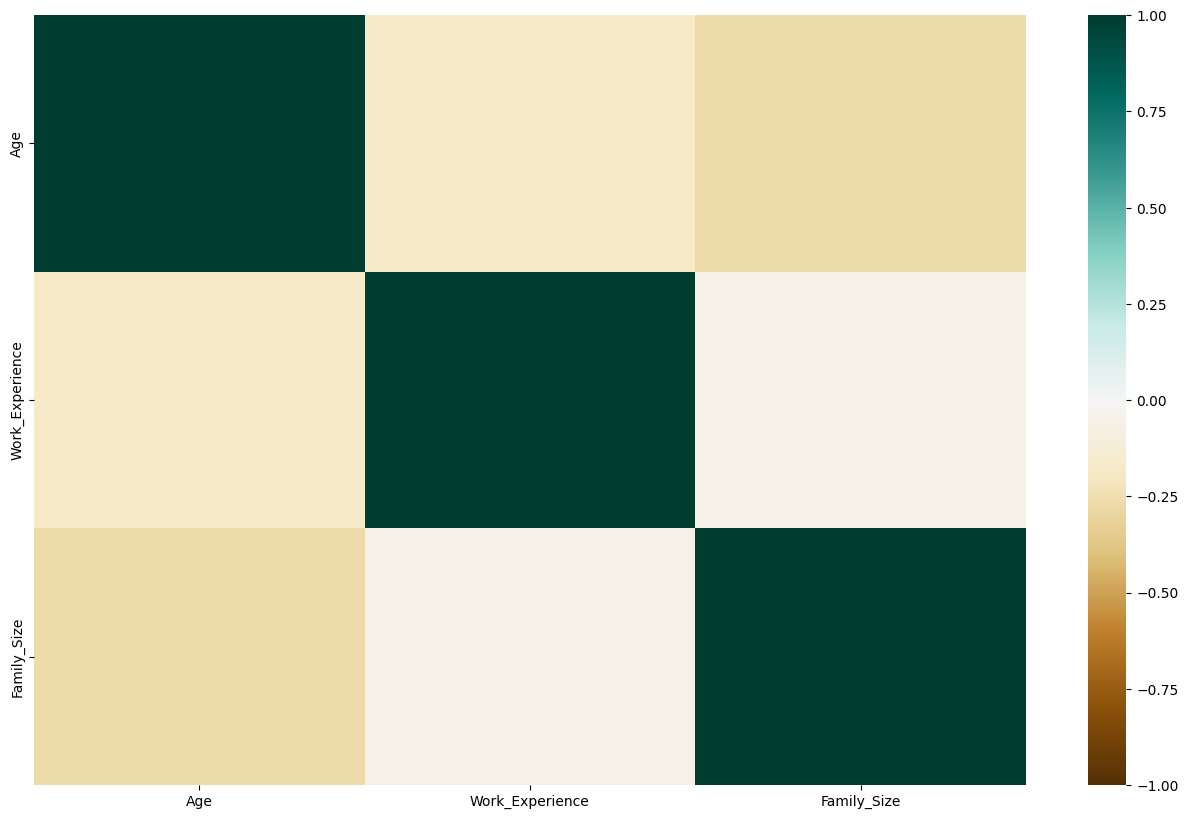

In [12]:
#Изобразим в виде тепловой карты
import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(df[numeric_columns].corr(),
            xticklabels=numeric_columns,
            yticklabels=numeric_columns,
            cmap="BrBG",
            vmin=-1,
            vmax=1)

plt.show()

In [13]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[numeric_columns], 10))

Top Absolute Correlations
Age              Family_Size        0.273291
                 Work_Experience    0.179361
Work_Experience  Family_Size        0.058702
dtype: float64


In [14]:
# Посмотрим на квазиконстантные признаки
from sklearn.feature_selection import VarianceThreshold

cutter = VarianceThreshold(threshold=0.1)
cutter.fit(df[numeric_columns])
cutter.get_feature_names_out()

array(['Age', 'Work_Experience', 'Family_Size'], dtype=object)

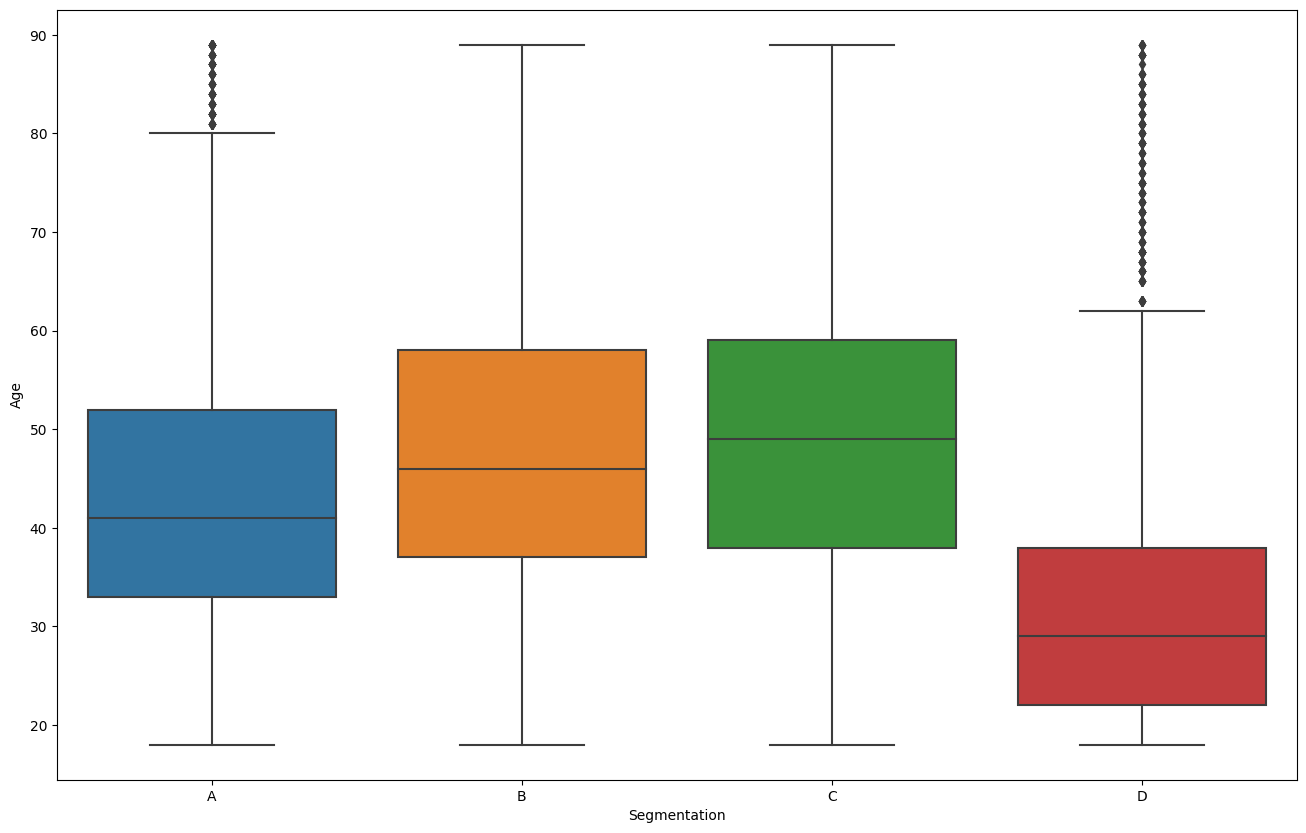

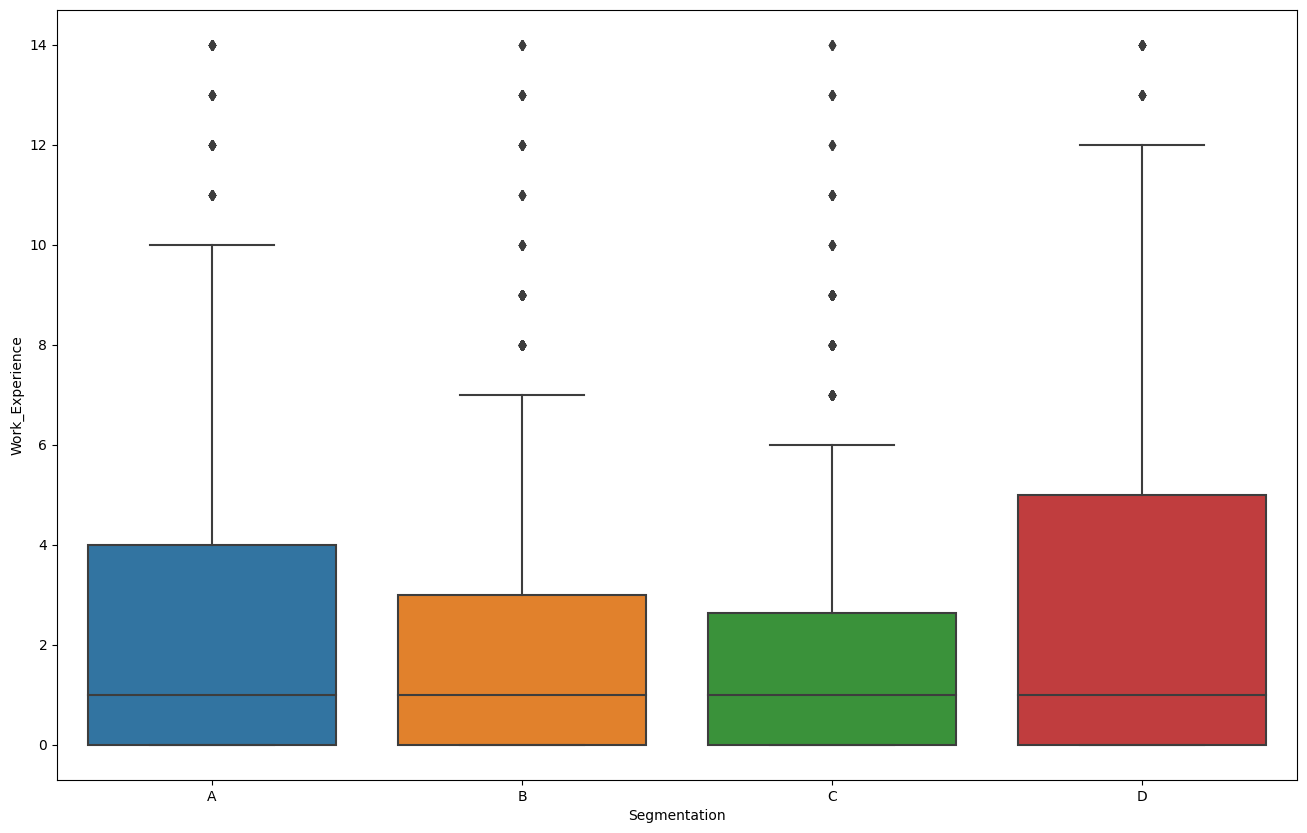

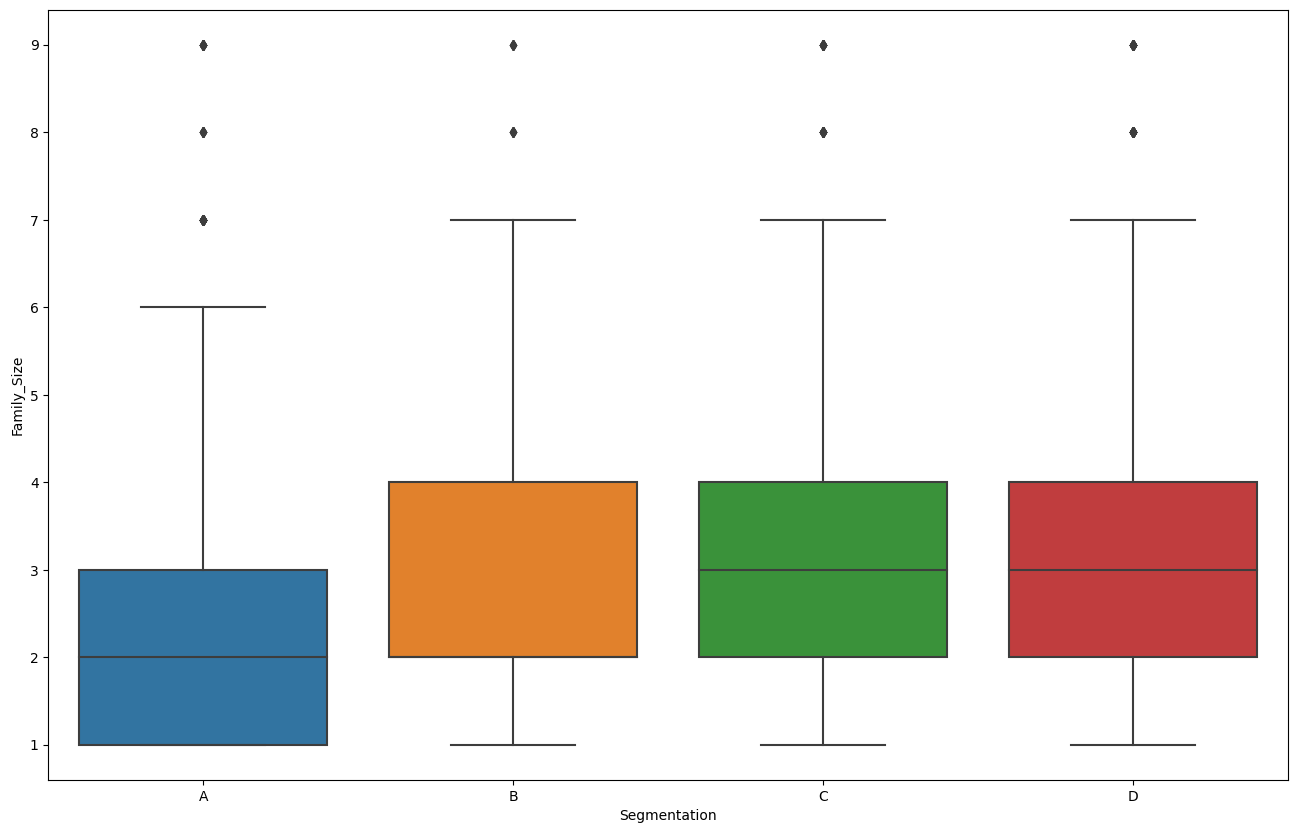

In [16]:
for col in numeric_columns:

    fig = plt.figure()
    fig.set_size_inches(16, 10)
    sns.boxplot(y=col, x = df["Segmentation"].astype('category'), data = df)
    plt.show()

In [17]:
#категориальные фичи
df.describe(include='object')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


In [18]:
#Заполним пропуски самым популярным классом
for col in categorical_columns:
    most_recent = df.groupby(col).size().sort_values().index[-1]
    df[col] = df[col].fillna(most_recent)
df.describe(include='object')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4783,5046,2640,4878,5314,2268


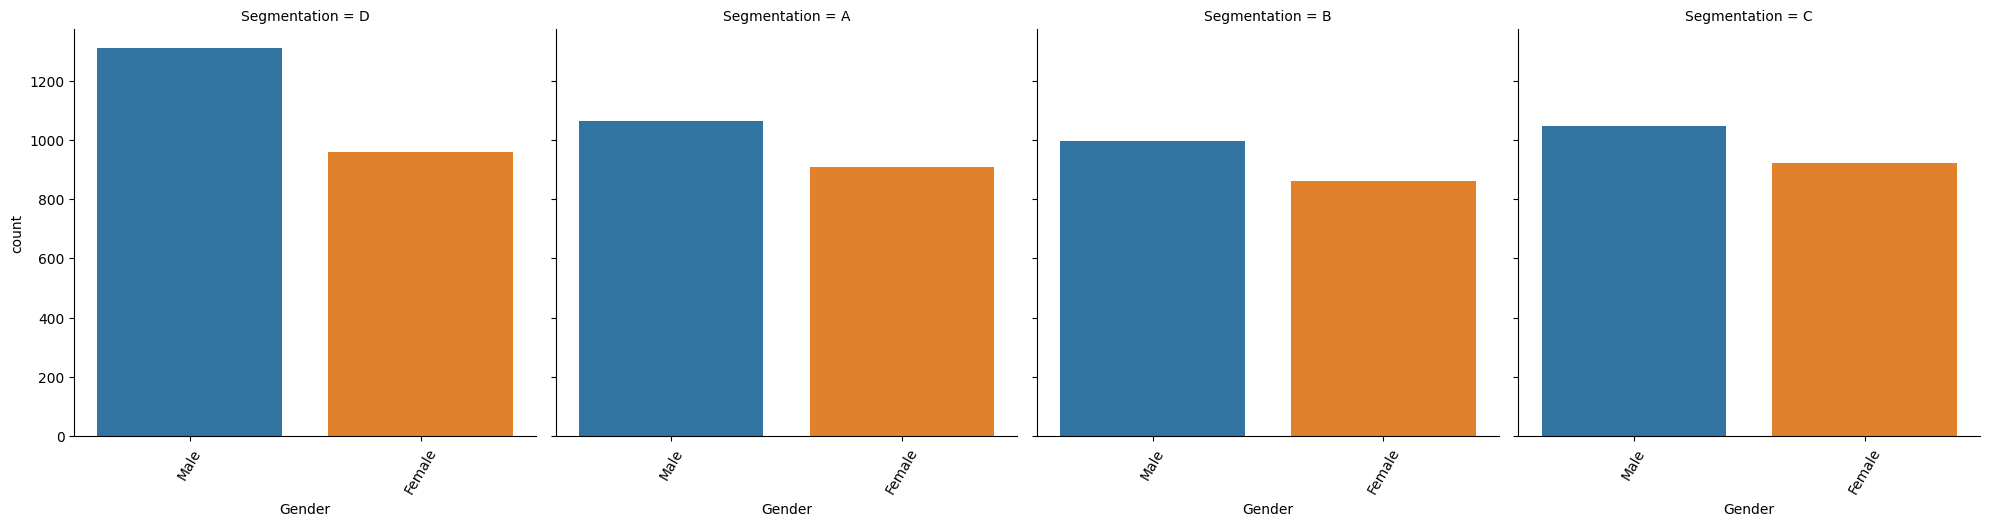

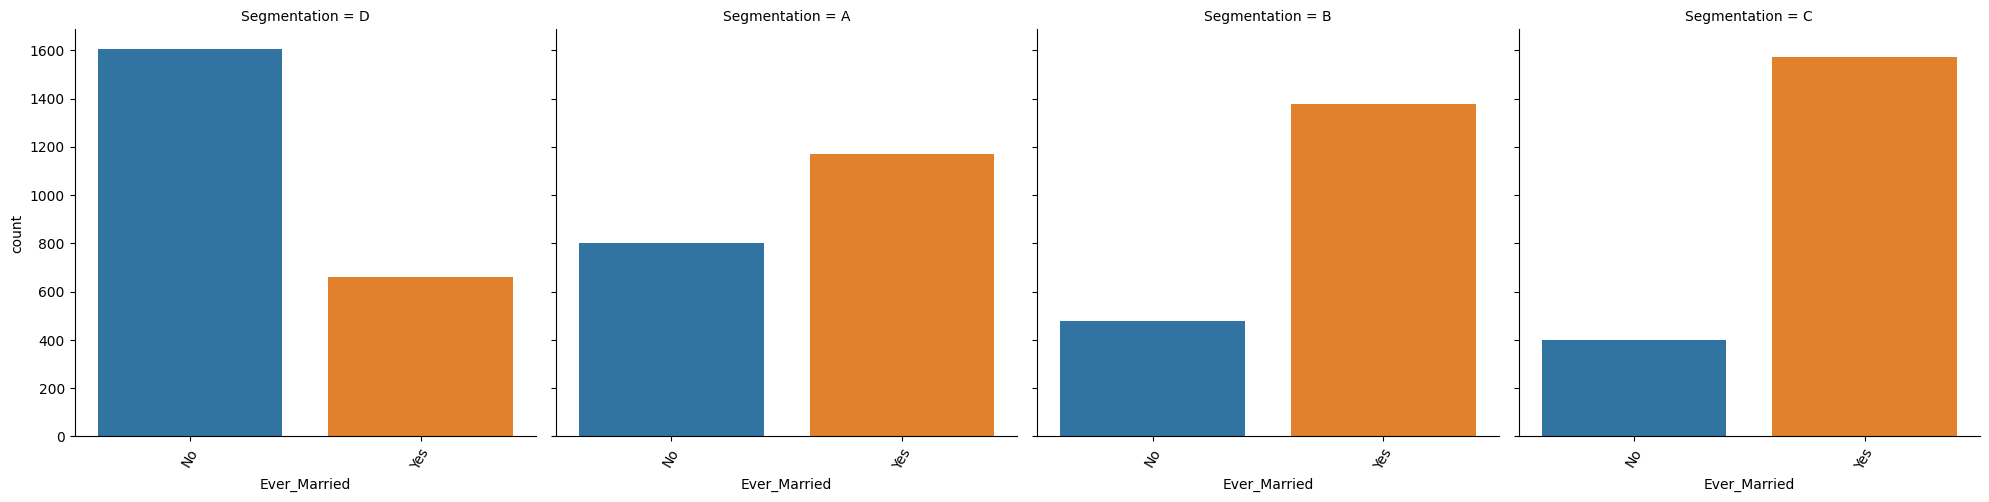

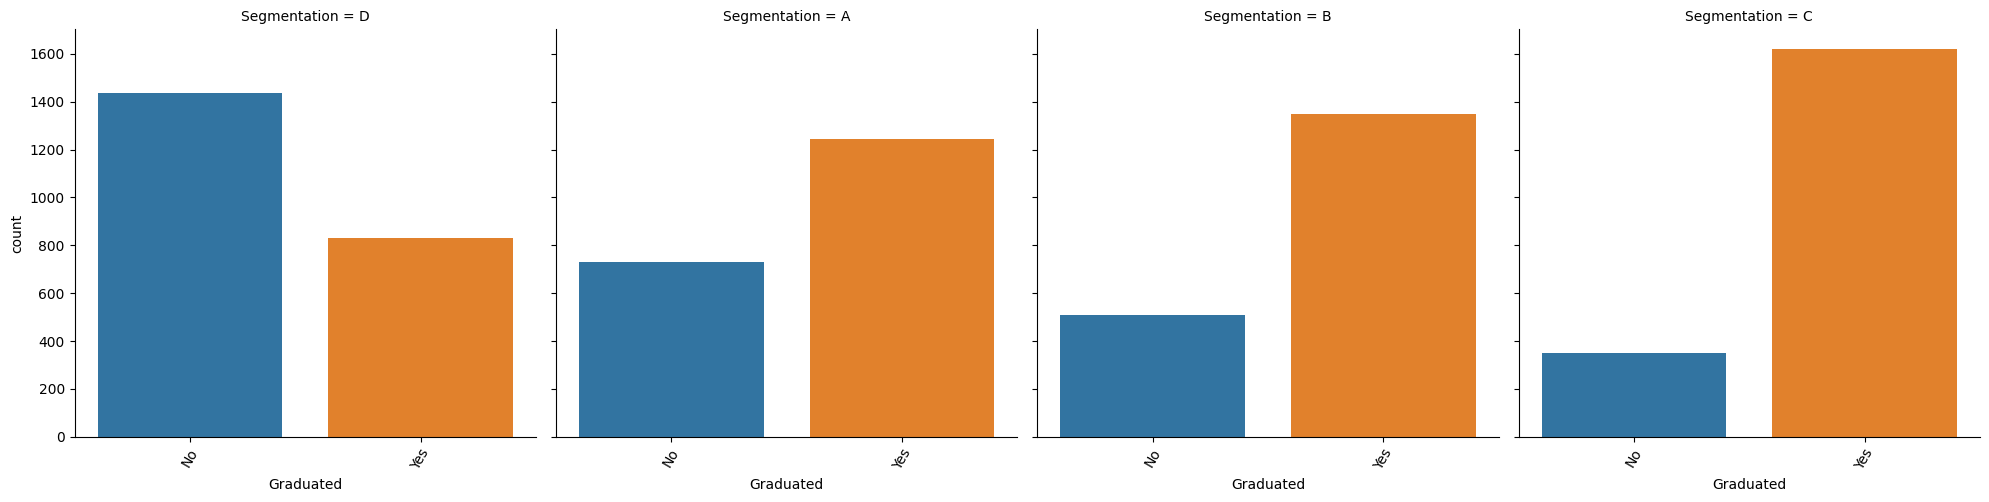

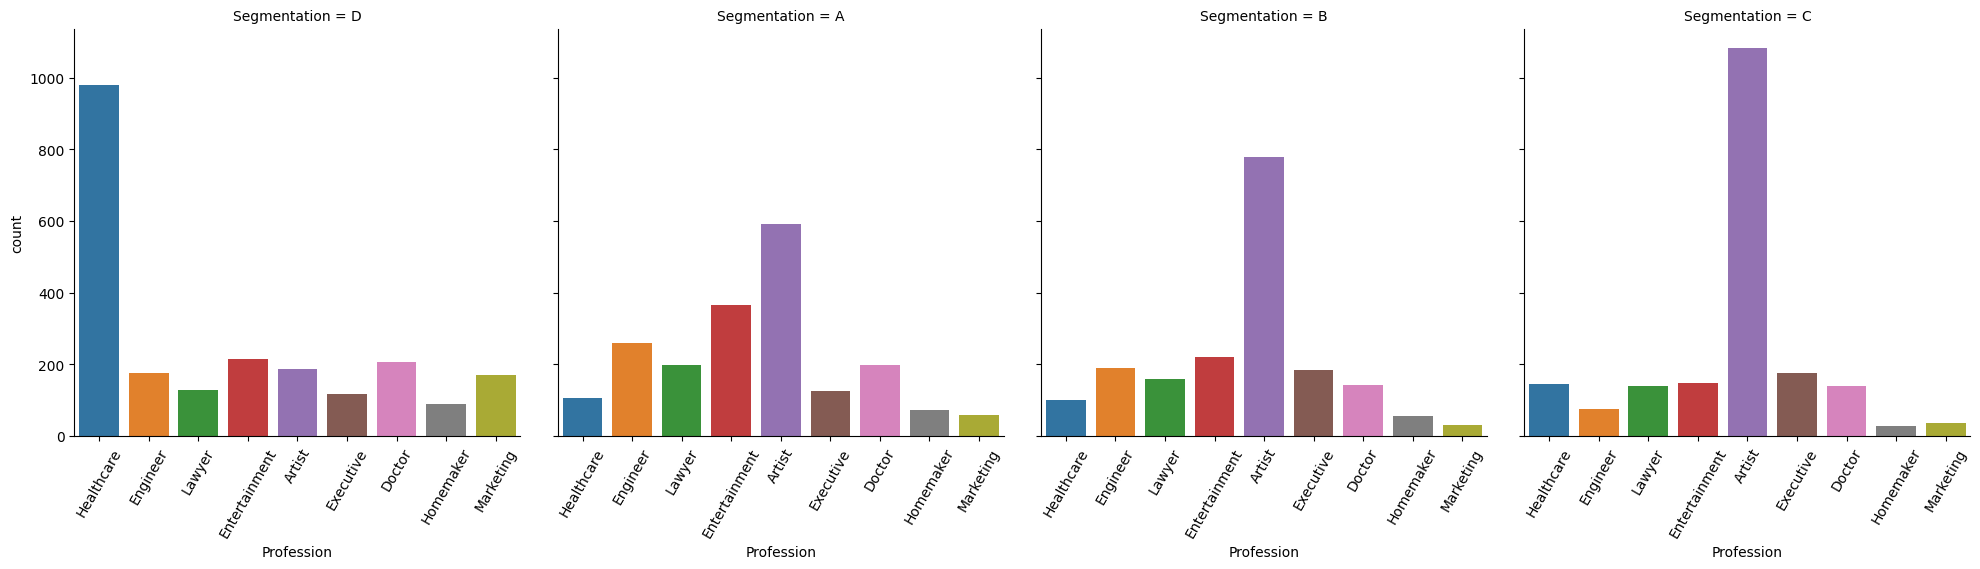

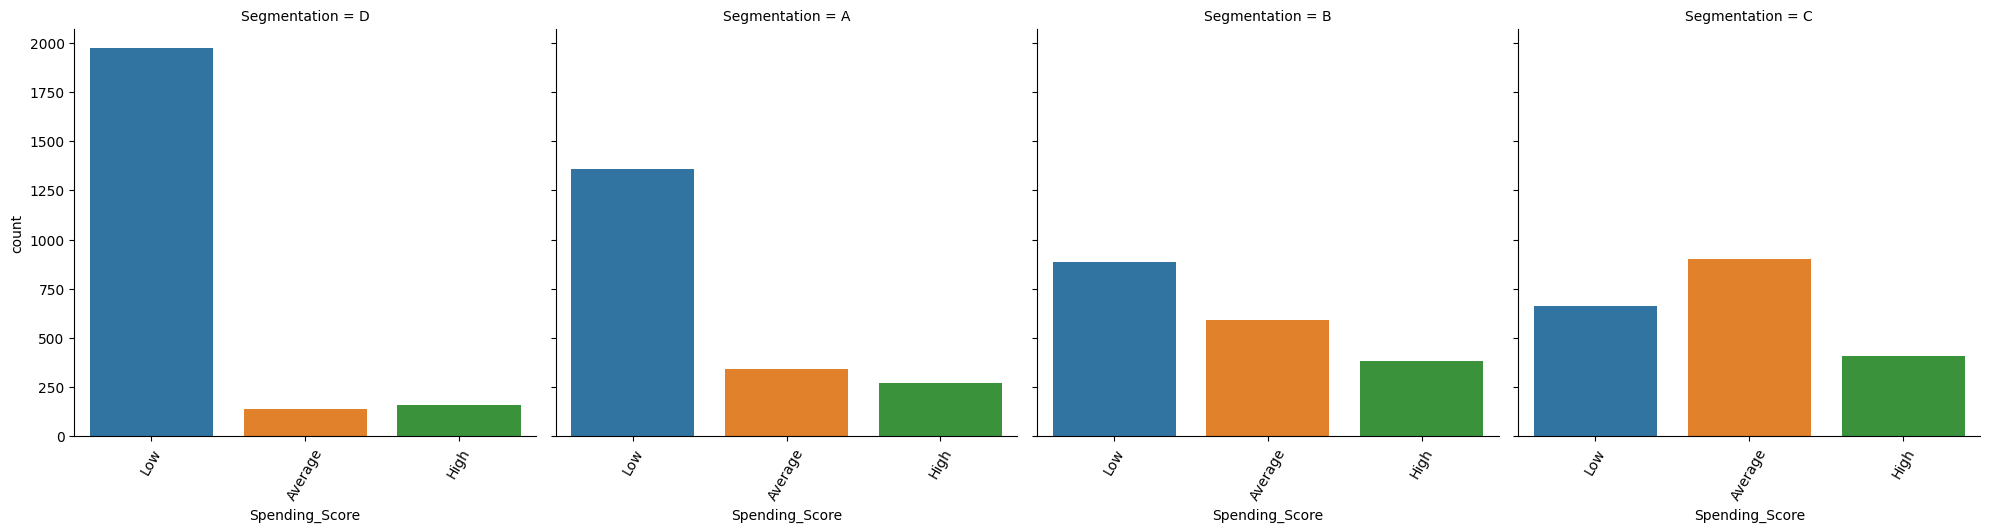

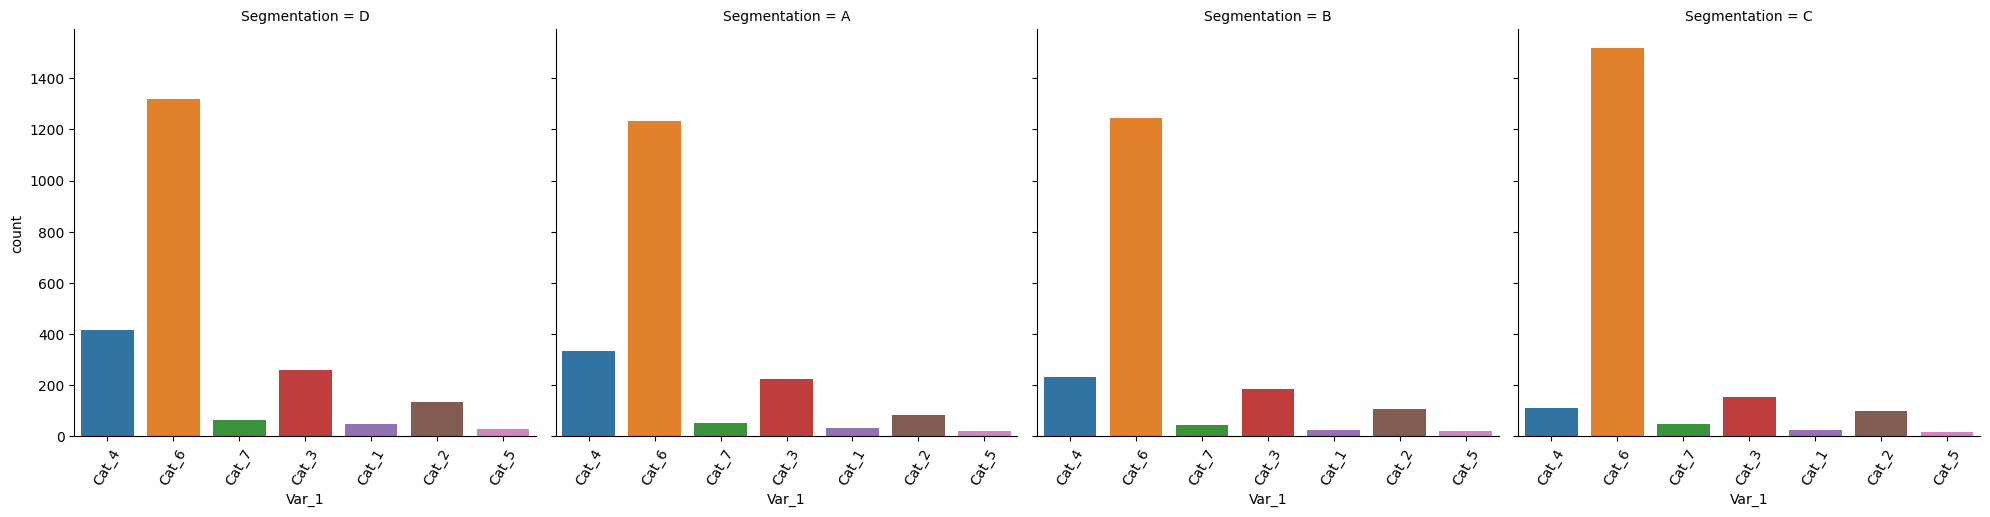

In [22]:
for col in categorical_columns:
    if col != "Segmentation":
        g = sns.catplot(x=col, kind='count', col="Segmentation", data=df)
        g.set_xticklabels(rotation=60)

In [23]:
#На основании графиков принимаем решение все фичи оставить, так как в зависимости от категории графики разнятся
#Закодируем категориальные фичи
#Напишем функцию мультиклассового энкодинга

def encode_multiclass_target(df, category, target="Segmentation"):
    df = df[[category, target]].copy()

    target_dummies = pd.get_dummies(df[target],
                                    prefix=category,
                                    drop_first=True)
    df = pd.concat((df, target_dummies), axis=1)

    for tg in target_dummies.columns:
        df[tg] = df.groupby(category)[tg].transform('mean')
    return  df.drop(category, axis=1)

### Под каждый класс создадим свою бинарную колонку

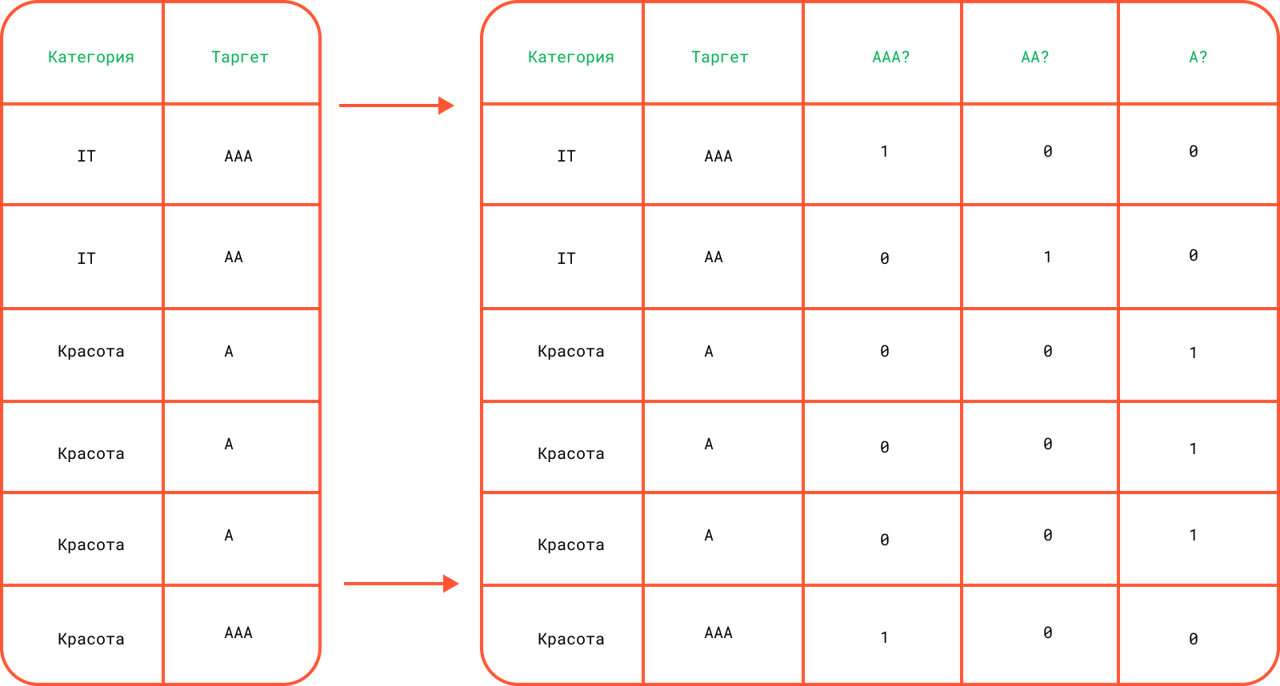

### Для каждой категории посчитаем долю единичек в каждой колонке
### Избавимся от одной, чтобы не словить мультиколлинеарность


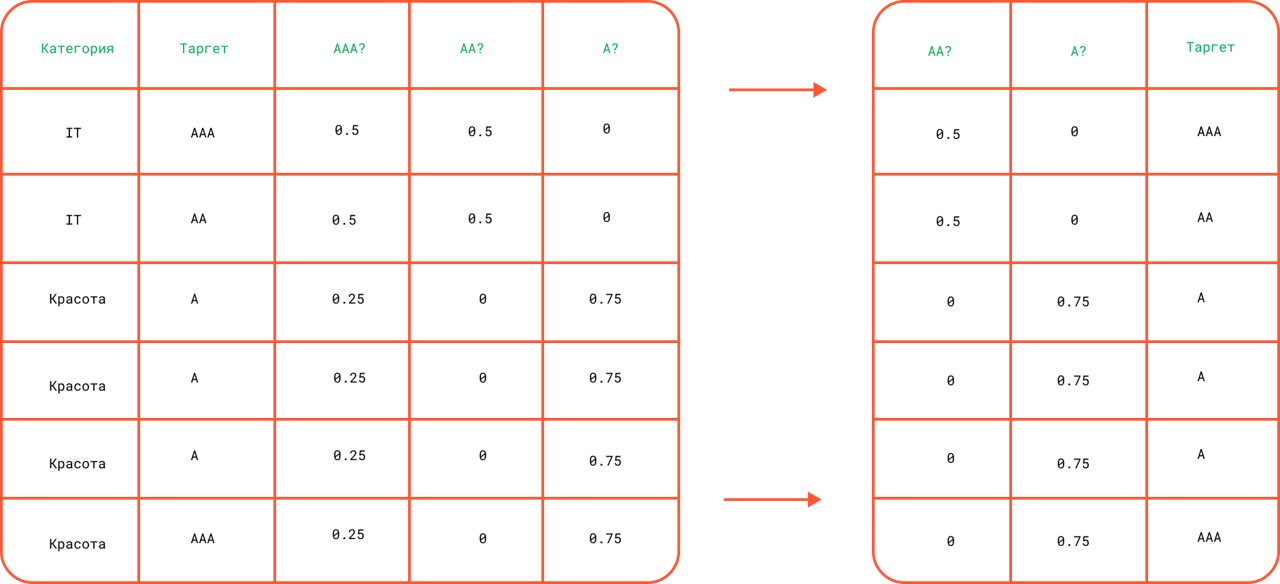

In [25]:
# закодируем
for col in categorical_columns.drop("Segmentation"):
    if df[col].nunique() < 4:
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

    else:
        mean_target = encode_multiclass_target(df, col).drop("Segmentation", axis=1)
        df = pd.concat((df.drop(col, axis=1), mean_target), axis=1)

In [26]:
X = df.drop("Segmentation", axis=1)
Y = df["Segmentation"]

In [27]:
Y.head()

ID
462809    D
462643    A
466315    B
461735    B
462669    A
Name: Segmentation, dtype: object

In [28]:
#Балансны ли классы?
Y.value_counts()
#В целом да, а значит можно считать Accuracy

D    2268
A    1972
C    1970
B    1858
Name: Segmentation, dtype: int64

Применим one VS all

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.2)

In [36]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier #параметр loss выбирает метод: опорные вектора или другие

SGDClassifier(loss='log')

pipe = Pipeline([('Scaler', StandardScaler()), ("one_vs_all", OneVsRestClassifier(SGDClassifier()))])

pipe.fit(X_train, Y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('one_vs_all', OneVsRestClassifier(estimator=SGDClassifier()))])

In [37]:
print(pipe.classes_)

print(pipe.predict(X_test.head(1)))

print(pipe.predict_proba(X_test.head(1)))

['A' 'B' 'C' 'D']
['C']


AttributeError: This 'OneVsRestClassifier' has no attribute 'predict_proba'

In [38]:
#замерим Accuracy
np.mean((pipe.predict(X_test) == Y_test))

0.4677819083023544

In [41]:
### Переберём различные параметры базовых моделей

from sklearn.model_selection import GridSearchCV

param_grid = {
    "one_vs_all__estimator__loss" : ['hinge', 'log', 'modified_huber',
                                   'squared_hinge', 'perceptron'],
    "one_vs_all__estimator__penalty" : ['l1', 'l2', 'elasticnet'],

    'one_vs_all__estimator__alpha' : [0.001, 0.01, 0.1, 0.5, 1, 10]
}

from sklearn.model_selection import PredefinedSplit

test_fold = [0 if x in X_train.index else -1 for x in X.index]
ps = PredefinedSplit(test_fold)

search = GridSearchCV(pipe, param_grid, cv=ps)

search.fit(X, Y)

print(f'Best parametr (CV score = {search.best_score_:.5f}):')
print(search.best_params_)

E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was 

Best parametr (CV score = 0.49303):
{'one_vs_all__estimator__alpha': 0.01, 'one_vs_all__estimator__loss': 'modified_huber', 'one_vs_all__estimator__penalty': 'l2'}


In [42]:
#Применим подход ALL vs ALL
from sklearn.multiclass import OneVsOneClassifier

pipe = Pipeline([('Scaler', StandardScaler()), ("all_vs_all", OneVsOneClassifier(SGDClassifier()))])

pipe.fit(X_train, Y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('all_vs_all', OneVsOneClassifier(estimator=SGDClassifier()))])

In [43]:
param_grid = {
    "all_vs_all__estimator__loss" : ['hinge', 'log', 'modified_huber',
                                   'squared_hinge', 'perceptron'],
    "all_vs_all__estimator__penalty" : ['l1', 'l2', 'elasticnet'],

    'all_vs_all__estimator__alpha' : [0.001, 0.01, 0.1, 0.5, 1, 10]
}



search = GridSearchCV(pipe, param_grid, cv=ps)

search.fit(X, Y)

print(f'Best parametr (CV score = {search.best_score_:.5f}):')
print(search.best_params_)

E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was 

Best parametr (CV score = 0.49861):
{'all_vs_all__estimator__alpha': 0.01, 'all_vs_all__estimator__loss': 'log', 'all_vs_all__estimator__penalty': 'l2'}


E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was 

In [44]:
#А помоги ли нам EDA?
from sklearn.model_selection import GridSearchCV

param_grid = {
    "all_vs_all__estimator__loss" : ['hinge', 'log', 'modified_huber',
                                   'squared_hinge', 'perceptron'],
    "all_vs_all__estimator__penalty" : ['l1', 'l2', 'elasticnet'],

    'all_vs_all__estimator__alpha' : [0.001, 0.01, 0.1, 0.5, 1, 10]
}



search = GridSearchCV(pipe, param_grid, cv=ps)

search.fit(X[numeric_columns], Y)

print(f'Best parametr (CV score = {search.best_score_:.5f}):')
print(search.best_params_)


E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was 

Best parametr (CV score = 0.42237):
{'all_vs_all__estimator__alpha': 0.001, 'all_vs_all__estimator__loss': 'modified_huber', 'all_vs_all__estimator__penalty': 'l1'}


In [45]:
#Да, помог!

In [46]:
#Попробуем улучшить модель полиномиальными фичами
X_polinomial = X.copy()

for col in numeric_columns:
    for power in [2, 3, 4]:

        to_add = (X_polinomial[col]**power).to_frame().rename({col:f"{col}_{power}"}, axis=1)
        X_polinomial = pd.concat((X_polinomial, to_add), axis=1)

In [47]:
X_polinomial.head()

,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D,Age_2,Age_3,Age_4,Work_Experience_2,Work_Experience_3,Work_Experience_4,Family_Size_2,Family_Size_3,Family_Size_4
ID,,,,,,,,,,,,,,,,,,,,,,,
462809,22,1.000000,4.0,1,0,0,0.075826,0.109610,0.734985,0,1,0.213039,0.100092,0.381084,484,10648,234256,1.000000,1.000000,1.000000,16.0,64.0,256.0
462643,38,2.641663,3.0,0,1,1,0.270386,0.107296,0.251788,0,0,0.213039,0.100092,0.381084,1444,54872,2085136,6.978385,18.434542,48.697851,9.0,27.0,81.0
466315,67,1.000000,1.0,0,1,1,0.270386,0.107296,0.251788,0,1,0.234287,0.285472,0.248400,4489,300763,20151121,1.000000,1.000000,1.000000,1.0,1.0,1.0
461735,67,0.000000,2.0,1,1,1,0.253612,0.224719,0.205457,1,0,0.234287,0.285472,0.248400,4489,300763,20151121,0.000000,0.000000,0.000000,4.0,8.0,16.0
462669,40,2.641663,6.0,0,1,1,0.232877,0.155954,0.226554,1,0,0.234287,0.285472,0.248400,1600,64000,2560000,6.978385,18.434542,48.697851,36.0,216.0,1296.0


In [49]:
### Полиномиальные фичи

from sklearn.model_selection import GridSearchCV

param_grid = {
    'all_vs_all__estimator__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'all_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'all_vs_all__estimator__alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]
}

from sklearn.model_selection import PredefinedSplit

search = GridSearchCV(pipe, param_grid, cv=ps)

search.fit(X_polinomial, Y)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
E:\ML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was 

Best parameter (CV score=0.50232):
{'all_vs_all__estimator__alpha': 0.01, 'all_vs_all__estimator__loss': 'hinge', 'all_vs_all__estimator__penalty': 'elasticnet'}


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score


print(f"""Precision равно: {precision_score(Y_test,
                                            pipe.predict(X_test),
                                            average='macro'):.3f}""" )

print(f"""Recall равно: {recall_score(Y_test,
                                      pipe.predict(X_test),
                                      average='macro'):.3f}""" )

print(f"""F-мера равно: {f1_score(Y_test,
                                  pipe.predict(X_test),
                                  average='macro'):.3f}""" )

Precision равно: 0.473
Recall равно: 0.477
F-мера равно: 0.472


In [51]:
print(f"""Precision равно: {precision_score(Y_test,
                                            pipe.predict(X_test),
                                            average='micro'):.3f}""" )

print(f"""Recall равно: {recall_score(Y_test,
                                      pipe.predict(X_test),
                                      average='micro'):.3f}""" )

print(f"""F-мера равно: {f1_score(Y_test,
                                  pipe.predict(X_test),
                                  average='micro'):.3f}""" )

Precision равно: 0.483
Recall равно: 0.483
F-мера равно: 0.483
